# RadioGenomics analysis pipeline
In this notebook, we provide a pipeline to perform disease subtype analysis with radiogenomics data. <br>
#### The data required to run this notebook: 
1. The image data in DICOM format.<br>
For more information on the format: <a>https://www.dicomstandard.org/</a>. <br>
If segmentation or region of  interest (ROI) is provided, we provide script to extract pre-defined radiomic features. <br>
The radiomic features are defined here: <br>
If no segmentation of ROI is provided, we recomend either (a) provide a custom feature extractor, or (b) extract features over the entire series. <br>
2. Genetic variant in VCF format.(Optional)
3. Gene expression data. (Optional)
#### Here is the coverage of this notebook: 
1. Extract radiomic feature using our provided script. 
2. Perform feature selection on radiomic, variant and gene expression data. 
3. Merging features to perform disease sub-type analysis. 
4. (Optional) A validation of clustering if true sub-type information is given. 
#### Dependencies: 
The notebook requires the following libraries: <br>
GATK <br>
Azure CLI <br>
Pydicom <a>https://pydicom.github.io/pydicom/stable/</a>

## 0. Dependencies
Notice src/utils.py is a provided helper code. ,<a>https://github.com/microsoft/genomicsnotebook/blob/main/docs/utils.py</a>
It contains: 
1. Helper functions to use. 
2. DICOM_sample, which is a provided helper data structure that extract the predifined radiomic featur

For more information about Pydicom: <a>https://pydicom.github.io/</a>. 


In [ ]:
pip install pydicom

In [1]:
#loading requried packages 
#for parsing data locations
import glob

#for analysis
import matplotlib.pylab as plt 
import pandas as pd
import numpy a Dataset

#for feature extraction: 
import pydicom as dicom 
from src.utils import *
from src.utils import dicom_sample


## 1. Extracting DICOM file feature 
To run this cell, change the varaible __data_path*__ accordingly. This should be the root of image data location.<br>
This cell will recursively find the locations of all the relevant image (and segmentation if appliable) and output the target location. 


In [ ]:
#getting the path of CT and segmentations 
data_root1 = './dataImageID1*'
g= glob.glob(data_root1) 
#sample size
N = len(g)
filmpath = [] 
for path in g:
    for film in glob.glob(path+"/*"):
        if ("-CT" in film):
            print (film)
            filmpath.append(film)
            break
        if any ("segmentation" in subpath for subpath in glob.glob(film+"/*")):
            print (film)
            filmpath.append(film)
            break
    


Given the target locations from the previous cell, __src/utils.py__ will take in the locations and extract the radiomic features while loading images. The features will be stored in a dataframe named __ dicom_feature_df__. 

In [ ]:
samples = []
for i in filmpath:
    print(i)
    sample = dicom_sample(i)
    if(sample.sample_id):
        print (sample.sample_id)
        samples.append(sample)
        
m_dict={}
for i in samples:
    i.getfeature() 
    features = np.concatenate((i.firstorderfeature, i.shapefeature))
    if features.shape[0] !=0: 
        m_dict[i.sample_id] = features

dicom_feature_df = pd.DataFrame(m_dict).transpose() 

(Optional) Save the extracted features for replicated usage. 


In [4]:
dicom_feature_df.to_csv("./data/dicom_features1.csv")

(Optional) Visualize the image data with identfied ROI. 

In [ ]:
from src.utils import dicom_sample
samples[0].display() 

## 3. Feature selection. 
In this this part, we will perform feature selection for: <br>
1. Radiomic features, <br>
2. Gene expression data, <br>
3. VCF data. 

#### 3.1 DICOM features clustering and feature selection

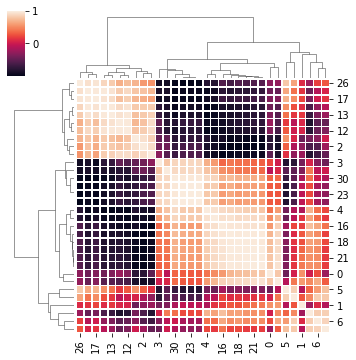

In [2]:
import pandas as pd
import seaborn as sns
dicom_feature= pd.read_csv("./data/dicom_features1.csv", header=0, index_col=0)
dicom_feature_similarities = dicom_feature.corr() 
pp = sns.clustermap(dicom_feature_similarities, linewidths=.5, figsize=(5,5))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)

plt.show()


#### 3.2 Gene expression feature selection
For gene expression data, we perform clustering and extract "meta-gene" for each cluster. We are using the meta-genes as representative features. In the following cell, we:<br>
3.2a Loading the gene expression data.<br>
3.2b Perform and visualize the clustering, in order to use the number of clusters to use.<br>
3.2c Choose the number of clusters touse, and extract the mata-genes. 

#### 3.2a Loading gene expression data to a data frame. Merge the comman samples with this the image data. 

In [7]:
#loading gene expression and clinical 
rna_seq = pd.read_table('./dataSample_RNAseq.txt',  header=0)
rna_seq  = rna_seq.set_index('Gene').transpose()


#### 3.2b Clustering and visualization of gene expression. 
The following cell performs standard quality control, clustering and visualization on gene expression data. It plots the top 5 levels of the hierarchical  clustering results. (__plot_level__ = 5). <br>
After plotting, one could decide the number of clusters (__n_clusters__) to fix on (30 in this demo). 


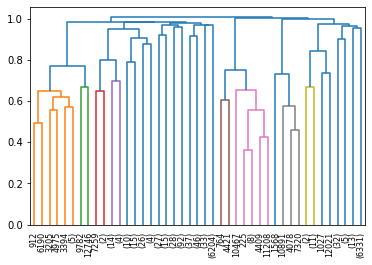

<Figure size 921.6x345.6 with 0 Axes>

In [8]:
#clustering for gene expression
import scipy
import scipy.cluster.hierarchy as hier 
import pylab as pl
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import nan_euclidean_distances 
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering



def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    #print(linkage_matrix)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



temp = rna_seq.loc[:, rna_seq.isnull().mean()< .5]
D = 1-temp.corr()
clustering = AgglomerativeClustering(n_clusters=None,affinity  ='precomputed' , linkage= 'average', distance_threshold=0)
clustering = clustering.fit(D) 
plot_level = 5
plot_dendrogram(clustering,truncate_mode='level', p=plot_level)
plt.figure(figsize=(12.8,4.8))
plt.show()
clustering = AgglomerativeClustering(n_clusters=30,affinity  ='precomputed' , linkage= 'average')
clustering = clustering.fit(D)

(Optional) Run the following cell to check the number of genes fall in each cluster to chech if the number of clusters are chosen reasonably. 

In [9]:
from collections import Counter 
gene_cluster_size =  Counter(clustering.labels_)
print(gene_cluster_size)

Counter({5: 4926, 0: 3701, 1: 1960, 2: 1288, 8: 229, 29: 84, 3: 83, 7: 64, 13: 55, 9: 49, 11: 47, 24: 45, 10: 42, 4: 40, 28: 38, 12: 37, 21: 33, 27: 31, 26: 30, 22: 30, 6: 28, 14: 28, 25: 26, 20: 21, 18: 15, 23: 14, 16: 13, 19: 12, 17: 11, 15: 4})


#### 3.2c Extract Metagene for each cluster with factor analysis
For each cluster, perform factor analysis (PCA), and use the first principle component as the meta gene. 

In [10]:
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.metrics import euclidean_distances
genes = rna_seq.loc[:, rna_seq.isnull().mean()< .5]
index_list= np.intersect1d(dicom_feature.index, rna_seq.index)
genes =  genes.reindex(index =index_list)

N = genes.shape[0]
n_clusters = 30
metagenes =[]
for i in range(n_clusters):
    geneset = genes.loc[:, clustering.labels_==i ]
    similarities  = geneset.transpose().corr() 
    mds = manifold.MDS(n_components=1, dissimilarity = 'precomputed')
    embedding = np.array(mds.fit_transform(similarities)).transpose()
    metagenes.append(embedding)
metagenes = np.array(metagenes).reshape(N, n_clusters)
column_names = ["Metagene"+str(i) for i in range (30)]
metagenes = pd.DataFrame(metagenes, index = index_list, columns=column_names)

In [11]:
print (len (index_list))

3


#### 3.3 Genetic feature
In this section, we perform stardard control on the genetic data, and use the eigenvectors of the LD(Linkage disequilibrium) with customer specified window size. 

Download the genetic data to local position. 

In [ ]:
pip install azure-storage-blob==2.1.0

In [ ]:
from azure.storage.blob import BlockBlobService, PublicAccess
blob_service_client = BlockBlobService(account_name='dataset1000genomes', sas_token='sv=2019-10-10&si=prod&sr=c&sig=9nzcxaQn0NprMPlSh4RhFQHcXedLQIcFgbERiooHEqM%3D')     
blob_service_client.get_blob_to_path('dataset/release/20130502' ,'ALL.chr22.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz','./ALL.chr22.phase3.vcf.gz')

In [ ]:
blob_service_client.get_blob_to_path('dataset/release/20130502' ,'ALL.chr22.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz.tbi','./ALL.chr22.phase3.vcf.gz.tbi')

In [ ]:
!wget https://github.com/broadinstitute/gatk/releases/download/4.2.2.0/gatk-4.2.2.0.zip

In [ ]:
!unzip gatk-4.2.2.0.zip

In [ ]:
#!./gatk-4.2.2.0/gatk SelectVariants -V ./ALL.chr22.phase3.vcf.gz --select-type SNP   --selectExpressions " AF > 0.1 " -O selected.vcf
!./gatk-4.2.2.0/gatk VariantsToTable -V ALL.chr22.phase3.vcf.gz -F CHROM -F POS -F ALT -F AF -F TYPE -GF GT  -O all.table


In [12]:
!awk '{if ($5=="SNP" && $4 > 0.1) print $0}' all.table | cut -f 1-155 > ./data/geno.sample

### Convert the genotype to allele counts, standardize the genotype matrix 

In [13]:
import pandas as pd 
import numpy as np 
genotype_vcf= pd.read_table("./data/geno.sample")
geno = np.zeros((genotype_vcf.shape[0], genotype_vcf.shape[1]-5))
print(geno.shape)
for i in range(geno.shape[0]):
    for j in range(geno.shape[1]):
        geno[i,j] = genotype_vcf.iloc[i, j+5].count(genotype_vcf.iloc[i,2])
        
np.savetxt("./data/geno.txt", geno.astype(int),  fmt='%i' ,delimiter=",") 

(113, 150)


In [ ]:
geno  = geno  - np.mean(geno, axis =1, keepdims= True) 
geno = geno / np.std(geno, axis=1, keepdims=True)
np.savetxt("./data/geno_standard.txt", geno, delimiter=",")

In [15]:
geno = np.genfromtxt("./data/geno_standard.txt", delimiter=',')

In [16]:
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.metrics import euclidean_distances
N = len(index_list)
window_size = 500
snp_num = geno.shape[0]
geno_block=[]
block_num = 0 
for i in range(0, snp_num, window_size): 
    end_idx = min(snp_num, i +window_size)
    geno_cur = geno[i:end_idx,0:N]
    geno_cur = pd.DataFrame(geno_cur)
    similarities  = geno_cur.corr() 
    mds = manifold.MDS(n_components=1, dissimilarity = 'precomputed')
    embedding = np.array(mds.fit_transform(similarities)).transpose()
    geno_block.append(embedding)
    block_num = block_num+1
geno_block = np.array(geno_block).reshape(N, block_num)
column_names = ["LDblock"+str(i) for i in range (block_num)]
geno_block = pd.DataFrame(geno_block, index = index_list, columns=column_names)

## 4. Disease subtype analysis: Clustering on patient
This part we merge the radiomic ,VCF  and gene expression feature we extracted ealier. We perform clustering to identify subtype of patients. 

In [ ]:
X = pd.concat([dicom_feature.reindex(index = index_list),metagenes, geno_block], axis=1, join = "inner")
print(X.shape)
all_feature_similarities = X.transpose().corr() 
pp = sns.clustermap(all_feature_similarities, linewidths=.5, figsize=(5,5))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)

plt.show()

## Reference libraries

1. Pydicom:https://pydicom.github.io/about
2. Pandas: https://pandas.pydata.org/
3. Numpy: https://numpy.org/

### END OF NOTEBOOK 


## Notices

THIS NOTEBOOK JUST PROVIDE A SAMPLE CODES FOR EDUCATIONAL PURPOSES. MICROSOFT DOES NOT CLAIM ANY OWNERSHIP ON THESE CODES AND LIBRARIES. MICROSOFT PROVIDES THIS NOTEBOOK AND SAMPLE USE OF ML LIBRARIES, SRC/utils.py codes ON AN “AS IS” BASIS. DATA OR ANY MATERIAL ON THIS NOTEBOOK. MICROSOFT MAKES NO WARRANTIES, EXPRESS OR IMPLIED, GUARANTEES OR CONDITIONS WITH RESPECT TO YOUR USE OF THIS NOTEBOOK. TO THE EXTENT PERMITTED UNDER YOUR LOCAL LAW, MICROSOFT DISCLAIMS ALL LIABILITY FOR ANY DAMAGES OR LOSSES, INCLUDING DIRECT, CONSEQUENTIAL, SPECIAL, INDIRECT, INCIDENTAL OR PUNITIVE, RESULTING FROM YOUR USE OF THIS NOTEBOOK.

Notebook prepared by Ariel WU- Research Intern- Microsoft Genomics